<a href="https://colab.research.google.com/github/kozz84/Image-analysis/blob/main/Image_analysis_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code

In [1]:
import glob, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image
import pandas as pd
import seaborn as sns

from skimage import io,morphology
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops, regionprops_table,perimeter
from skimage.color import label2rgb

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
def loadfile(filepath):
    img = io.imread(filepath, as_gray=True)
    img = np.array(img).astype(np.int32)
    txtfile= filepath.split('.')[0]+'.txt'
    with open(txtfile,'r') as txt_file:
        txt = txt_file.read()
        del txt_file
        txt=txt.split('\n')
        txt=txt[1:-1]
        sem_dict = {}
        for row in txt:
            row = row.split('=')
            sem_dict.update({row[0]:  row[1]}) 
        width, height = sem_dict['DataSize'].split('x')
        width, height = int(width), int(height)
        if height == 1920:
            img = img[0:1780,0:2560]
            height = 1780
        pixelsize = float(sem_dict['PixelSize'])
        print('FILE NAME:',sem_dict['ImageName'])
        print('DATE:',sem_dict['Date'] )   
        print('IMAGE SIZE [pixels]:', width,'x',height, ) 
        print('PIXEL SIZE [nm]:', sem_dict['PixelSize'],)

        print('IMAGE SIZE [nm]:', 
            round(width*float(sem_dict['PixelSize']),0), 
            'x',
            round(height*float(sem_dict['PixelSize']),0))
        print('IMAGE AREA [nm]:', width*float(sem_dict['PixelSize'])*height*float(sem_dict['PixelSize']))
        image_area = width*float(sem_dict['PixelSize'])*height*float(sem_dict['PixelSize'])
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(img,vmax=255, cmap='gray')
    plt.show()
    return img, sem_dict,width, height,pixelsize,image_area

In [3]:
def image_info(img):
    im = img.copy()
    print('Max:',im.max())
    print('Min:',im.min())
    print('Median:',np.median(im))
    print('Average:',np.average(im))
    im_flatten = im.flatten()
    print('IMAGE:')
    im_flatten = im.flatten()
    plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.imshow(im,vmax=255, cmap='gray')
    plt.show()

    print('IMAGE HIST:')
    plt.figure(figsize=(4,2))
    plt.hist(im_flatten, bins=256,histtype='stepfilled', range=(im.min(),im.max()))
    plt.yscale('log')
    plt.show()

    median_img=[]
    
    average_img =[]
    max_img = []
    num_rec_x=20
    num_rec_y=20
    rec_size_x = int(int(height)/num_rec_x)
    rec_size_y = int(int(width)/num_rec_y)
    for i in range(num_rec_x):
        for j in range(num_rec_y):
            x_min=i*rec_size_x
            y_min=j*rec_size_y
            x_max=x_min+rec_size_x
            y_max=y_min+rec_size_y
            median_img.append(int(np.median(im[x_min:x_max,y_min:y_max])))
            average_img.append(int(np.average(im[x_min:x_max,y_min:y_max])))
            max_img.append(int(np.max(im[x_min:x_max,y_min:y_max])))
    print('Average:')            
    plt.figure(figsize=(10,8))
    plt.plot(average_img)
    plt.show()
    #plt.plot(max_img)
    plt.boxplot(median_img)
    plt.show()
    Q1 = np.percentile(median_img , 25)
    print(Q1)
    Q3 = np.percentile(median_img , 75)
    print(Q3)
    IQR = Q3 - Q1
    upper_bound = Q3+(1.5*IQR)
    lower_bound = Q1-(1.5*IQR)
    print(upper_bound)
    print(lower_bound)
    median_img = np.reshape(median_img, (20, 20))
    average_img =np.reshape(average_img,(20,20))
    max_img=np.reshape(max_img,(20,20))
    print('Median_HM')
    plt.figure(figsize=(17, 10))
    sns.heatmap(median_img,annot=True,fmt='.0f')
    plt.axis(False)
    plt.show()
    print('Average_HM')
    plt.figure(figsize=(17, 10))
    sns.heatmap(average_img,annot=True,fmt='.0f')
    plt.axis(False)
    plt.show()
    print('max/average_HM')
    plt.figure(figsize=(17, 10))
    sns.heatmap(max_img/average_img,annot=True,fmt='.0f')
    plt.axis(False)
    plt.show()

In [342]:
def uniform(num_rec_x,num_rec_y):
    img2 = np.copy(img)
    img2 = denoise_tv_chambolle(img2, weight=6)
    rec_size_x = int(int(height)/num_rec_x)
    rec_size_y = int(int(width)/num_rec_y)
    print("Median Rectangle Box size:",rec_size_x,"x", rec_size_y)
    print("Median intensity:",np.median(img))
    median_img=[]
    mask = np.zeros(shape=(1780,2560), dtype=bool)
    for i in range(num_rec_x):
        for j in range(num_rec_y):
            x_min=i*rec_size_x
            y_min=j*rec_size_y
            x_max=x_min+rec_size_x
            y_max=y_min+rec_size_y
            if j == (num_rec_y-1):
                y_max = width
            if i == (num_rec_x-1):
                x_max = height
            median_img.append(np.median(img[x_min:x_max,y_min:y_max]))
            img2[x_min:x_max,y_min:y_max]=img[x_min:x_max,y_min:y_max] - np.median(img[x_min:x_max,y_min:y_max])
    Q1 = np.percentile(median_img , 25)
    Q3 = np.percentile(median_img , 75)
    IQR = Q3 - Q1
    upper_bound = Q3+(1.5*IQR)
    lower_bound = Q1-(1.5*IQR)

    for i in range(num_rec_x):
        for j in range(num_rec_y):
             x_min=i*rec_size_x
             y_min=j*rec_size_y
             x_max=x_min+rec_size_x
             y_max=y_min+rec_size_y
             if np.median(img[x_min:x_max,y_min:y_max]) > upper_bound or np.median(img[x_min:x_max,y_min:y_max]) < lower_bound :
                #print(np.median(img[x_min:x_max,y_min:y_max]))
                img2[x_min:x_max,y_min:y_max] = 0
                mask[x_min:x_max,y_min:y_max] = True
    img2[img2<0] = 0
    mask[0,0:]=True
    mask[-1,0:]=True
    mask[0:,0]=True
    mask[0:,-1]=True
    return img2, median_img, mask

In [5]:
def histograms():
    img_flatten = img.flatten()
    img2_flatten = img2.flatten()
    fig, (ax1, ax2) = plt.subplots(2)
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    fig.suptitle('Histograms')
    ax1.hist(img_flatten, bins=256, range=(0,255))
    ax2.hist(img2_flatten, bins=256, range=(0,155))

In [75]:
#SEGMENTATION

In [202]:
def label_img():
    img2_label = label(img_segm)
    #img2_label = clear_border(img2_label, mask=mask,bgval=0)
    img2_label_overlay = label2rgb(img2_label, bg_label=0)
    props = regionprops(img2_label, extra_properties=())
    props = regionprops_table(img2_label, img_segm,
                           properties=['mean_intensity',
                                       'area',
                                       'convex_area',
                                       'equivalent_diameter', 
                                       'major_axis_length', 
                                       'minor_axis_length',
                                       'bbox', 'perimeter',
                                       'feret_diameter_max', 
                                       'image',
                                       'convex_image'
                                       ]
                              )
    props = pd.DataFrame(props)
    props['img'] = [img]*len(props)
    for i in range(len(props)):
        props.loc[i,'img'] = [img[int(props['bbox-0'][i]):int(props['bbox-2'][i]),
                                  int(props['bbox-1'][i]):int(props['bbox-3'][i])]]
    data_nm = props.copy()
    data_nm['convex_perimeter'] = data_nm['convex_image'].apply(lambda x: perimeter(x))
    data_nm = data_nm.drop(columns=[
                                 #   'image',
                                    'bbox-0', 
                                    'bbox-1', 
                                    'bbox-2', 
                                    'bbox-3',
                              #      'img',
                           #         'mean_intensity',
                                  #  'convex_image'
                                    ])
    to_nm = ['equivalent_diameter',
       'major_axis_length', 'minor_axis_length', 'perimeter',
       'feret_diameter_max', 'convex_perimeter']

    to_nm2 = ['area', 'convex_area']
    data_nm['circularity'] = np.sqrt(4*np.pi*data_nm['area']/(data_nm['perimeter'])**2)
    data_nm.loc[data_nm['circularity'] >1 ,'circularity'] = 1
    for column in to_nm:
        data_nm[column] = data_nm[column].apply(lambda x:x*pixelsize)
    for column in to_nm2:
        data_nm[column] = data_nm[column].apply(lambda x:x*pixelsize*pixelsize)
    data_nm['aspect_ratio'] = data_nm['minor_axis_length']/data_nm['major_axis_length']
    data_nm['solidity'] =data_nm['area']/data_nm['convex_area']
    data_nm.loc[(data_nm['convex_perimeter'] >data_nm['perimeter']), 'convex_perimeter'] = data_nm.loc[(data_nm['convex_perimeter'] >data_nm['perimeter']), 'perimeter'].values
    data_nm['convexity'] = data_nm['convex_perimeter']/data_nm['perimeter']
    data_nm['area_fraction']=data_nm['area']/image_area
    csv_file_name=sem_dict['ImageName'].split('.')[0]
    data_nm.to_csv(csv_file_name+'.csv')
    return img2_label, img2_label_overlay, data_nm

In [8]:
def quick_label_img():
    img2_label = label(img_segm)
    img2_label = clear_border(img2_label, mask=mask)
    particles = img2_label.max()
    return particles

# User inteactions

FILE NAME: 210902_#3_50_30_1um_i003.tif
DATE: 09/03/2021
IMAGE SIZE [pixels]: 2560 x 1780
PIXEL SIZE [nm]: 2.480469
IMAGE SIZE [nm]: 6350.0 x 4415.0
IMAGE AREA [nm]: 28036743.932750277


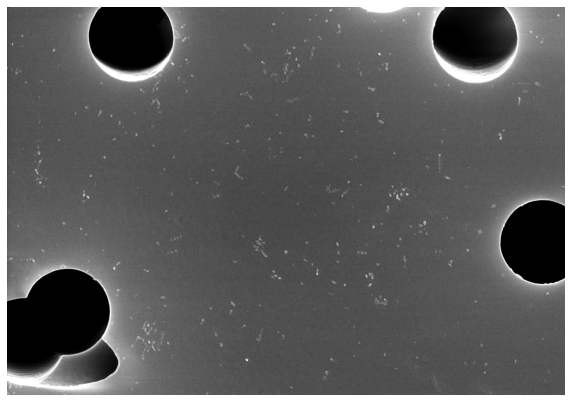

In [355]:
img,sem_dict,width, height,pixelsize,image_area = loadfile('/content/210902_#3_50_30_1um_i003.tif')

In [356]:
#pd.DataFrame(sem_dict,index=[0]).T

In [357]:
#image_info(img)

In [358]:
img2, median_img,mask = uniform(20,20)

Median Rectangle Box size: 89 x 128
Median intensity: 85.0


In [373]:
unique, counts = np.unique(mask, return_counts=True)
area_size_mask = dict(zip(unique, counts))

In [387]:
a

3662929

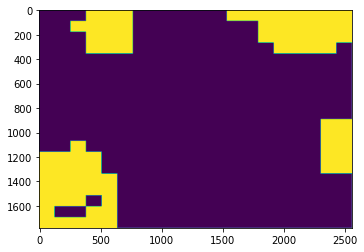

In [359]:
plt.imshow(mask)

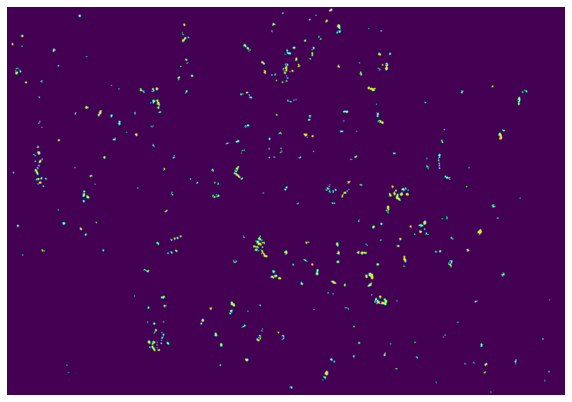

In [360]:
def segmentation(low,denoise=6,small=15,erosion=1):
    img_denoised = denoise_tv_chambolle(img2, weight=denoise)
    img_denoised = img2.copy()
    img_segm = (img2 > np.median(img_denoised)+low) & (img_denoised <= 255)
    img_segm = img_segm+mask
    img_segm = clear_border(img_segm)
    img_segm = morphology.remove_small_objects(img_segm, small)
    img_segm = morphology.area_closing(img_segm)
    #for i in range(erosion):
    #    img_segm = morphology.binary_erosion(img_segm)
    #img_segm = morphology.remove_small_objects(img_segm, small)
    #for i in range(erosion-1):     
    #    img_segm = morphology.binary_dilation(img_segm)
    #img_segm = morphology.binary_dilation(img_segm)
    #img_segm = morphology.binary_erosion(img_segm)
    #plt.imshow(img_segm[1000:1500,500:1000])
    #plt.axis('off')
    #plt.show()

    return img_segm


img_segm = segmentation(20)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img_segm)
plt.show()

In [361]:
img2_label, img2_label_overlay, data_nm = label_img()

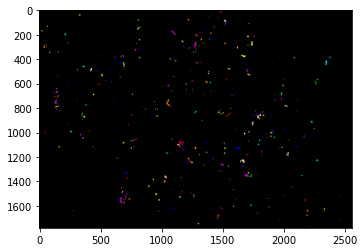

In [362]:
plt.imshow(img2_label_overlay, vmax=1)

In [363]:
data_nm[data_nm['area']!=data_nm['area'].max()]['area_fraction'].sum()

0.007919153792134833

In [364]:
data_nm['area_fraction'].sum()

0.008027782654494383

In [365]:
bin_file_name = sem_dict['ImageName'].split('.')[0]+'_bin.png'
io.imsave(bin_file_name,img2_label_overlay)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: 210902_#3_50_30_1um_i003_bin.png is a low contrast image
  


In [366]:
mask_file_name = sem_dict['ImageName'].split('.')[0]+'_mask.png'
io.imsave(mask_file_name,mask)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: 210902_#3_50_30_1um_i003_mask.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  


# New Section

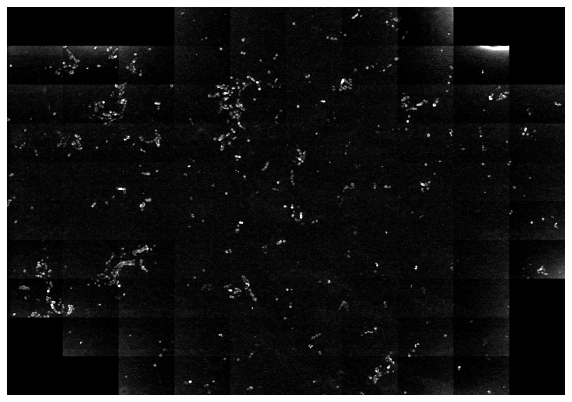

In [31]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img2,vmax=100, cmap='gray')
plt.show()

In [ ]:
#image_info(img2)

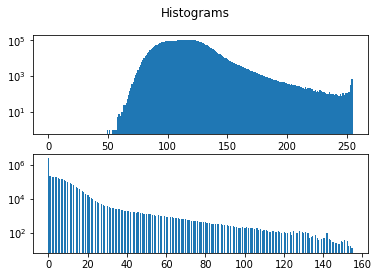

In [ ]:
histograms()

1%, 2%, 3%, 4%, 5%, 6%, 7%, 8%, 9%, 10%, 11%, 12%, 13%, 14%, 15%, 16%, 17%, 18%, 19%, 20%, 21%, 22%, 23%, 24%, 25%, 26%, 27%, 28%, 29%, 30%, 31%, 32%, 33%, 34%, 35%, 36%, 37%, 38%, 39%, 40%, 41%, 42%, 43%, 44%, 45%, 46%, 47%, 48%, 49%, 50%, 51%, 52%, 53%, 54%, 55%, 56%, 57%, 58%, 59%, 60%, 61%, 62%, 63%, 64%, 65%, 66%, 67%, 68%, 69%, 70%, 71%, 72%, 73%, 74%, 75%, 76%, 77%, 78%, 79%, 80%, 81%, 82%, 83%, 84%, 85%, 86%, 87%, 88%, 89%, 90%, 91%, 92%, 93%, 94%, 95%, 96%, 97%, 98%, 99%, 100%, 

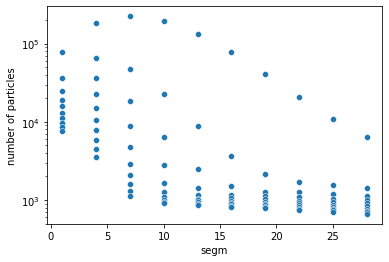

In [ ]:
show_images = False
max_cutoff = 30
min_size = 30
step=3
do_fitting = True
particles = []
counter=0
if show_images and do_fitting:
    plt.imshow(img[1000:1500,500:1000],vmin=0,cmap='gray')
    plt.text(440,30,'img',backgroundcolor='white')
    plt.axis('off')
    plt.show()
if do_fitting:
    for i in range(1,max_cutoff+1,step):
        for j in range(1,min_size+1,step):
            counter+=1
            print(round(counter/((max_cutoff/step)*(min_size/step))*100), end = '%, ')
            img_segm = segmentation(i,6,j,1)
            #img2_label, img2_label_overlay, data_nm = label_img()
            if show_images:
                plt.imshow(img_segm[1000:1500,500:1000],vmin=0,cmap='gray')
                plt.text(450,50,i,backgroundcolor='white')
                plt.axis('off')
                plt.show()
            n_particles = quick_label_img()
            particles.append([i,j,n_particles])
    particles = pd.DataFrame(particles, columns=(['segm','low','number of particles']))

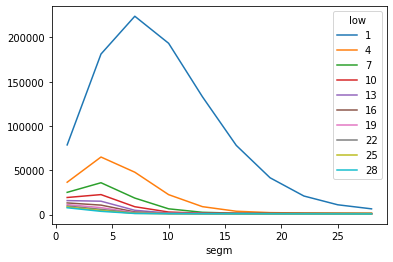

In [ ]:
pd.pivot_table(particles,'number of particles', index='segm',columns='low').plot()

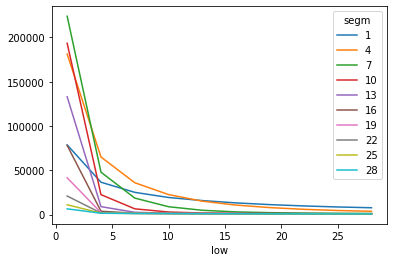

In [ ]:
pd.pivot_table(particles,'number of particles', index='low',columns='segm').plot()

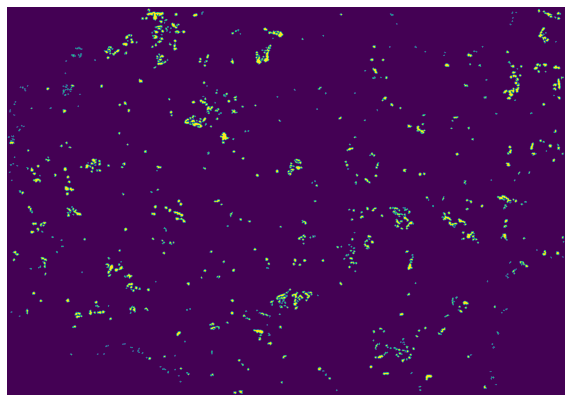

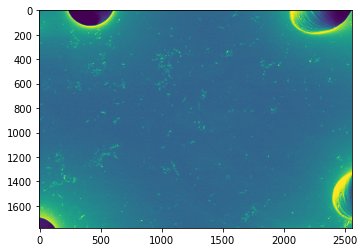

In [195]:
plt.imshow(img)

# Data presantation

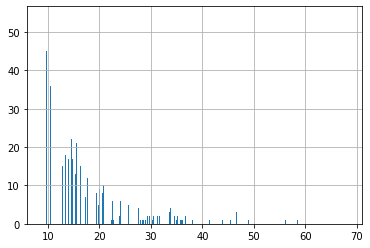

In [ ]:
data_nm['equivalent_diameter'].hist(bins=1000)

In [ ]:
data_nm.sort_values('area',ascending=False).head(10).index

Int64Index([111, 1015, 2800, 2063, 2271, 3193, 3087, 349, 340, 1194], dtype='int64')

In [ ]:
data_nm.iloc[3193]

mean_intensity                                                155.238313
area                                                         6712.624568
convex_area                                                  9536.726013
equivalent_diameter                                            92.448791
major_axis_length                                             142.776171
minor_axis_length                                              71.246973
perimeter                                                     580.857922
feret_diameter_max                                            161.230485
image                  [[False, True, True, True, False, False, False...
convex_image           [[False, True, True, True, True, True, False, ...
img                    [[113, 122, 126, 124, 111, 106, 105, 109, 114,...
convex_perimeter                                              403.349493
circularity                                                     0.500013
aspect_ratio                                       

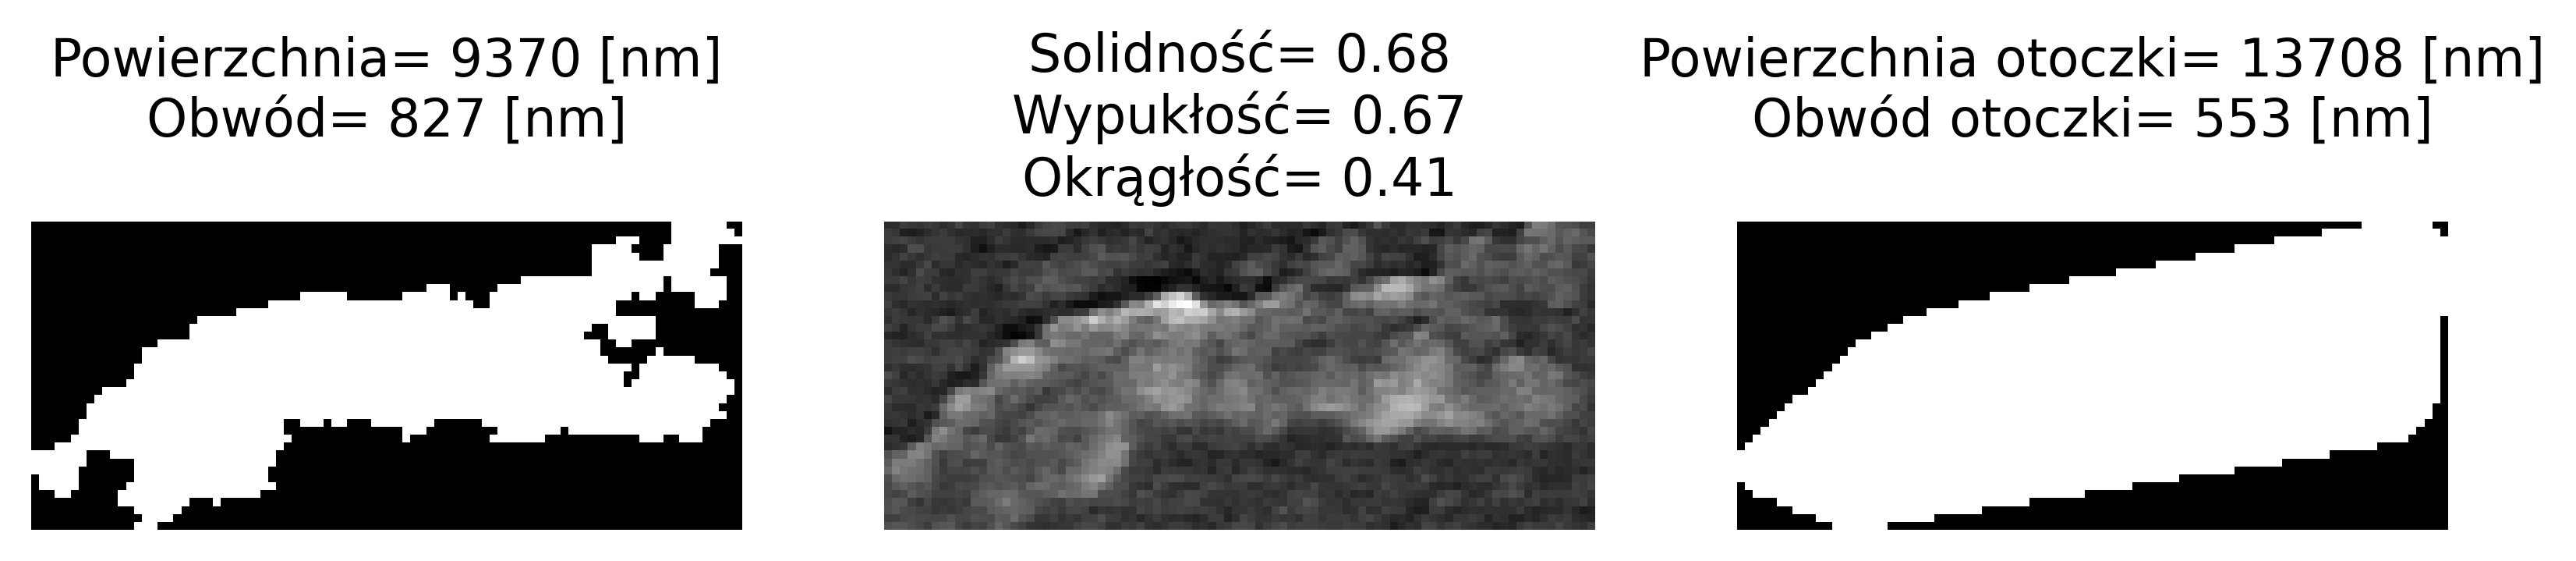

In [98]:
index=543
plt.figure(figsize=(10,10),dpi=400)
plt.subplot(1,3,1)
plt.axis('off')
plt.title('Powierzchnia= '+str(int(data_nm['area'][index]))+' [nm]\n'
          'Obwód= '+str(round(data_nm['perimeter'][index]))+' [nm]\n')
plt.imshow(data_nm['image'][index],cmap='gray')
plt.subplot(1,3,2)
plt.axis('off')
plt.title('Solidność= '+str(round(data_nm['solidity'][index],2))+'\n'
        'Wypukłość= '+str(round(data_nm['convexity'][index],2))+'\n'
        'Okrągłość= '+str(round(data_nm['circularity'][index],2)))
plt.imshow(data_nm['img'][index],cmap='gray')
plt.subplot(1,3,3)
plt.axis('off')
plt.title('Powierzchnia otoczki= '+str(int(data_nm['convex_area'][index]))+' [nm]\n'
           'Obwód otoczki= '+str(round(data_nm['convex_perimeter'][index]))+' [nm]\n')
plt.imshow(data_nm['convex_image'][index],cmap='gray')
plt.show()

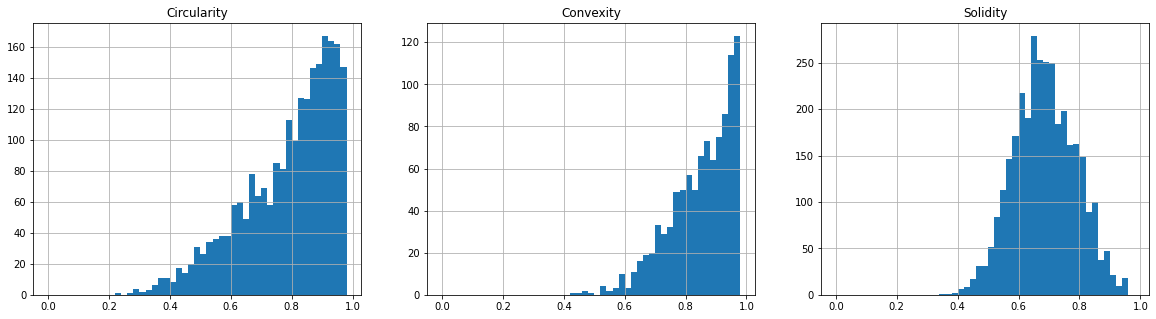

In [ ]:
bins = np.arange(0, 1, 0.02)
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.title('Circularity')
data_nm['circularity'].hist(bins=bins)

plt.subplot(1,3,2)
plt.title('Convexity')
data_nm['convexity'].hist(bins=bins)

plt.subplot(1,3,3)
plt.title('Solidity')
data_nm['solidity'].hist(bins=bins)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: 210902_#9_150_30_1um_i003_bin.png is a low contrast image
  
